# In this notebook, I'm going to practice a powerful technique called transfer learning and be replicating a machine learning research paper.

Course practice: https://github.com/mrdbourke/pytorch-deep-learning

## Imports

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from pathlib import Path
import requests
import zipfile
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
import random
from typing import Tuple, Dict, List

In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

## Usful class and basic setup

In [ ]:
class Helper():

    def __init__(self, device: torch.device):
        self.device = device

    def download_data(self,
                      source: str,
                      destination: str,
                      remove_source: bool=True) -> Path:

        # Path to data folder
        data_path = Path('data/')
        image_path = data_path / destination

        # If image folder doesn't exist, dowload and prepare it
        if image_path.is_dir():
            print(f'{image_path} is already exists')
        else:
            print(f'Did not find {image_path} directory, creating it')
            image_path.mkdir(parents=True, exist_ok=True)

            # Download data from source
            target_file = Path(source).name

            with open(data_path / target_file, 'wb') as f:
                request = requests.get(source)
                print(f'Downloading {target_file} form {source}')
                f.write(request.content)

            # Unzip data from target file:
            with zipfile.ZipFile(data_path / target_file, 'r') as zip:
                print(f'Unzipping {target_file}')
                zip.extractall(image_path)

            if remove_source:
                os.remove(data_path / target_file)

        return image_path

    def create_dataloaders(self,
                           train_dir: str,
                           test_dir: str,
                           transform: transforms.Compose,
                           batch_size: int,
                           num_workers: int=os.cpu_count()):

        # Create custom datasets by using ImageFolder
        train_dataset = datasets.ImageFolder(train_dir, transform=transform)
        test_dataset = datasets.ImageFolder(test_dir, transform=transform)

        # Get class names
        class_names = train_dataset.classes

        # Turn images into data loaders
        train_dataloader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=True
                                      )
        test_dataloader = DataLoader(dataset=test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

        return train_dataloader, test_dataloader, class_names

    def set_seeds(self, seed: int=42):

        # Set the seed for general torch operations
        torch.manual_seed(seed)

        # Set the seed for CUDA torch operations (ones that happen on the GPU)
        torch.cuda.manual_seed(seed)

    def train_step(self,
                   model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   device: torch.device) -> Tuple[float, float]:

        # Put model in train mode
        model.train()

        # Setup train loss and train accuracy
        train_loss, train_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3 must have
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss /= len(dataloader)
        train_accuracy /= len(dataloader)

        return train_loss, train_accuracy

    @torch.inference_mode()
    def test_step(self,
                  model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  device: torch.device) -> Tuple[float, float]:

        # Put model in eval mode
        model.eval()

        # Setup test loss and test accuracy
        test_loss, test_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

        return test_loss, test_accuracy

    def train(self,
              model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epochs: int,
              device: torch.device) -> Dict[str, List[float]]:

        res = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

        # Loop through training and testing steps for a number of epochs
        for epoch in tqdm(range(epochs)):
            train_loss, train_accuracy = self.train_step(model=model,
                                                         dataloader=train_dataloader,
                                                         loss_fn=loss_fn,
                                                         optimizer=optimizer,
                                                         device=device)
            test_loss, test_accuracy = self.test_step(model=model,
                                                      dataloader=test_dataloader,
                                                      loss_fn=loss_fn,
                                                      device=device)

            # Logs
            print(f'Epoch: {epoch + 1} | '
                  f'train loss: {train_loss:.4f} | '
                  f'train accuracy: {train_accuracy:.4f} | '
                  f'test loss: {test_loss:.4f} | '
                  f'test accuracy: {test_accuracy:.4f}')

            # Update results
            res['train_loss'].append(train_loss)
            res['train_acc'].append(train_accuracy)
            res['test_loss'].append(test_loss)
            res['test_acc'].append(test_accuracy)

        return res

    def plot_loss_accuracy_curves(self, results: Dict[str, List[int]]):

        # Get train loss, test loss, train accuracy, test accuracy from dict
        train_loss = results['train_loss']
        train_accuracy = results['train_acc']
        test_loss = results['test_loss']
        test_accuracy = results['test_acc']

        # Figure out how many epochs there are
        epochs = range(len(train_loss))

        # Setup the plot
        plt.figure(figsize=(15, 7))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label='Train accuracy')
        plt.plot(epochs, test_accuracy, label='Test accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.legend()

    @torch.inference_mode()
    def predict_and_mb_plot(self,
                            model: torch.nn.Module,
                            image_path: str,
                            class_names: List[str],
                            device: torch.device,
                            image_size: Tuple[int, int]=(224, 224),
                            transform: torchvision.transforms=None,
                            make_plot: bool=False):

        # Open Image
        image = Image.open(image_path)

        # Create transformation for image
        if transform:
            image_transform = transform
        else:
            image_transform = transform
            image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(mean=[.485, .456, .406],
                                                                                  std=[.229, .224, .225])])

        # Predict label (class)
        # Make sure the model is on the target device
        model.to(device)

        # Put model to eval mode
        model.eval()

        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(image).unsqueeze(dim=0)

        # Calculate logits on image with an extra dimension and send it to the target device
        logits = model((transformed_image).to(device))

        # Calculate probability and make a prediction
        probability = torch.softmax(logits, dim=1)
        predicted = torch.argmax(probability, dim=1)

        # Plot image with predicted label and probability
        if make_plot:
            plt.figure()
            plt.imshow(image)
            plt.title(f'Pred: {class_names[predicted]} | Prob: {probability.max():.3f}')
            plt.axis(False)
        else:
            return predicted, torch.round(probability.max(), decimals=3)

    def save_model(self,
                   model: torch.nn.Module,
                   target_dir: str,
                   model_name: str):

        # Create target directory
        target_dir_path = Path(target_dir)
        target_dir_path.mkdir(parents=True,
                              exist_ok=True)

        # Create model save path
        assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
        model_save_path = target_dir_path / model_name

        # Save model's state_dict()
        print(f'Model saved in {model_save_path}')
        torch.save(obj=model.state_dict(),
                   f=model_save_path)

    @torch.inference_mode()
    def make_prediction(self,
                        model: torch.nn.Module,
                        data: list,
                        device: torch.device) -> torch.Tensor:

        probs, preds = [], []
        model.eval()
        if type(data[0]) is tuple:
            data = [data[i][0] for i in range(len(data))]
        for sample in data:
            # Add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Calculate logits on image with an extra dimension and send it to the target device
            logits = model(sample)
            # Calculate probability
            probability = torch.softmax(logits, dim=1)
            probs.append(probability.cpu())
            predicted = torch.argmax(probability, dim=1)
            preds.append(predicted.cpu())

        # Stack probabilities and predictions into tensors
        probs = torch.cat(probs, dim=0)
        preds = torch.cat(preds, dim=0)

        return probs, preds

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
helper = Helper(device)

In [ ]:
# Create global variables
BATCH_SIZE = 32
NUM_CLASSES = 3
IMG_SIZE = 224
OUT_SHAPE = 768

## Block 2: replicating a machine learning research paper

Going to be replicating the machine learning research paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper) with PyTorch
Sourse: https://arxiv.org/abs/2010.11929

In [ ]:
# Let's create paths for training and testing directoreis
image_path = helper.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                  destination='pizza_steak_sushi')

train_dir = image_path / 'train'
test_dir = image_path / 'test'

Did not find data/pizza_steak_sushi directory, creating it
Unzipping pizza_steak_sushi.zip


In [ ]:
# As we can see, all training is performed with a resolution of 224
# Let's add a new one to our global variables - IMG_SIZE = 224
# And create a transform pipeline
manual_transform = transforms.Compose([transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()])

In [ ]:
# In the original, BATCH_SIZE is 4096
# It's too expensive, so let's use 32
# Setup data loaders
train_dataloader, test_dataloader, class_names = helper.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transform,
                                                                           batch_size=BATCH_SIZE)

### Equation 1 overview

This equation deals with the class token, patch embedding and position embedding (E is for embedding) of the input image.

In vector form, the embedding might look something like:

x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

In [ ]:
# Calculating number of patches
height, width, color_channels, patch_size = IMG_SIZE, IMG_SIZE, 3, 16
number_of_patches = int((height * width) / patch_size**2)

# Calculating patch embedding input and output shapes
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")
# New global variable OUT_SHAPE = 768

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [ ]:
# Creating image patches with torch.nn.Conv2d()
conv2d = nn.Conv2d(in_channels=color_channels,
                   out_channels=OUT_SHAPE,
                   kernel_size=(patch_size, patch_size),
                   stride=patch_size,
                   padding=0)

In [ ]:
# Let's test on one random image
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

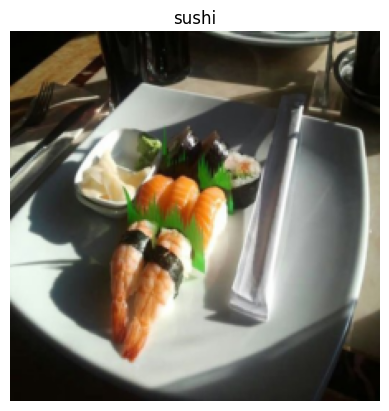

In [ ]:
plt.imshow(image.permute(1, 2, 0))  # image.shape = [color_channels, height, width] but mpl like image.shape = [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Pass image through the conv2d
image_out_of_conv2d = conv2d(image.unsqueeze(dim=0))  # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv2d.shape)
# [batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


[490, 459, 190, 113, 596]


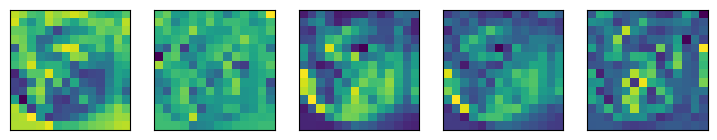

In [ ]:
# Plot random 5 conv feature features
rows, cols, n = 1, 5, 5
random_idxs = random.sample(range(OUT_SHAPE), k=n)
print(random_idxs)
fig, ax = plt.subplots(rows, cols, figsize=(9, 9))
for i, idx in enumerate(random_idxs):
    image_conv_feature_map = image_out_of_conv2d[:, idx, :, :]  # index on the output tensor of the convolutional layer
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Only want to flatten the "spatial dimensions of the feature map"
# Which in this case is the feature_map_height and feature_map_width dimensions of image_out_of_conv
flatten = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                     end_dim=3)  # flatten feature_map_width (dimension 3)

In [ ]:
# Flattening the patch embedding with torch.nn.Flatten()
image_out_of_conv2d_flattened = flatten(image_out_of_conv2d)
print(f"Flattened image feature map shape: {image_out_of_conv2d_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [ ]:
# Wanna [batch_size, num_patches, embedding_size] but now have [batch_size, embedding_size, num_patches]
image_out_of_conv2d_flattened_reshaped = image_out_of_conv2d_flattened.permute(0, 2, 1)
print(f"Flattened image feature map shape: {image_out_of_conv2d_flattened_reshaped.shape}")

Flattened image feature map shape: torch.Size([1, 196, 768])


(-0.5, 195.5, 0.5, -0.5)

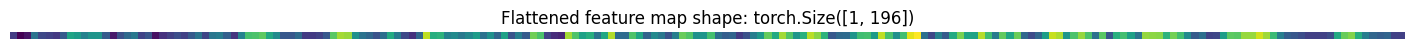

In [ ]:
# Get a single flatten feature map
single_flattened_feature_map = image_out_of_conv2d_flattened_reshaped[:, :, 0]
plt.figure(figsize=(18, 18))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

In [ ]:
# Create the patch embedding into a single PyTorch layer
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):

        super().__init__()

        # A layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=(patch_size, patch_size),
                                 stride=patch_size,
                                 padding=0)
        # A layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # Forward pass
    def forward(self, x):

        # Assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [ ]:
# Check
helper.set_seeds()
patchify = PatchEmbedding(in_channels=color_channels, patch_size=patch_size, embedding_dim=OUT_SHAPE)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# Creating the class token embedding
class_token = nn.Parameter(data=torch.randn(1, 1, OUT_SHAPE),  # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True)
print(f'Class token shape: {class_token.shape}')

Class token shape: torch.Size([1, 1, 768])


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.0298, -0.0063, -0.0322,  ...,  0.0185, -0.0090,  0.0092],
         [-0.2239,  0.0199, -0.0241,  ...,  0.1530, -0.0877,  0.0157],
         ...,
         [-0.1131,  0.0228, -0.0625,  ...,  0.0849, -0.0809,  0.0354],
         [-0.0044, -0.0392, -0.0298,  ...,  0.0096, -0.0269,  0.0357],
         [-0.0313, -0.0086, -0.0443,  ...,  0.0430, -0.0086,  0.0028]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Creating the position embedding
position_embedding = nn.Parameter(data=torch.randn(1, number_of_patches + 1, OUT_SHAPE),  # [batch_size, number_of_patches, embedding_dimension]
                                  requires_grad=True)

print(f'Position embeddding shape: {position_embedding.shape}')

Position embeddding shape: torch.Size([1, 197, 768])


In [ ]:
# Position embeddings created!
# Let's add them to our sequence of patch embeddings with a prepended class token
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f'Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape}')

Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768])


In [ ]:
# Let's put all together
helper.set_seeds()

# Original shape
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# Get image tensor and add batch dimenstion
img = image.unsqueeze(dim=0)
print(f'Input image with batch dim shape: {img.shape}')

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=color_channels, patch_size=patch_size, embedding_dim=OUT_SHAPE)

# Pass the img through patch embedding layer
patch_embedding = patch_embedding_layer(img)
print(f'Patch embedding shape: {patch_embedding.shape}')

# Create token embedding
class_token = nn.Parameter(data=torch.randn(1, 1, OUT_SHAPE),
                           requires_grad=True)
print(f'Class token shape: {class_token.shape}')

# Concatenate token embedding patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# Create position embedding
position_embedding = nn.Parameter(data=torch.randn(1, number_of_patches+1, OUT_SHAPE),
                                  requires_grad=True)

# Positon embedding + prev results
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dim shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2 overview

This says that for every layer from 1 through to L (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection.

We'll call this layer the "MSA block".

In pseudocode, this might look like:

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 attention_dropout: float=.0):

        super().__init__()

        # Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multi-head attention layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attention_dropout)

    # Forward pass
    def forward(self, x):
        normalized_x = self.layer_norm(x)
        attention_output, _ = self.multihead_attention(query=normalized_x,  # query embedding
                                                       key=normalized_x,  # key embedding
                                                       value=normalized_x,  # value embedding
                                                       need_weights=False)

        return attention_output
# skip connection will be added as the result

In [ ]:
# Check
multi_head_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=OUT_SHAPE, num_heads=12)  # num_heads from table 1
patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Equation 3 overview

This says that for every layer from 1 through to L (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,  # from table 1
                 dropout: float=.1):  # from table 3

        super().__init__()

        # Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # MLP layer
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,
                                           out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,
                                           out_features=embedding_dim),
                                 nn.Dropout(p=dropout))

    # Forward pass
    def forward(self, x):
        normalized_x = self.layer_norm(x)
        return self.mlp(normalized_x)
# skip connection will be added as the result

In [ ]:
# Check
mlp_block = MLPBlock(embedding_dim=OUT_SHAPE, mlp_size=3071, dropout=.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Equation 4 overview

This says for the last layer L, the output y is the 0 index token of z wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of x_output_MLP_block:

y = Linear_layer(LN_layer(x_output_MLP_block[0]))

#### Assembling the model

In [ ]:
# Creating a Transformer Encoder by combining our custom made layers
class TransformEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: float=.1,
                 attention_dropout: float=.0):

        super().__init__()

        # MSE block
        self.mse_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attention_dropout=attention_dropout)

        # MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    # Forward pass
    def forward(self, x):

        x = self.mse_block(x) + x  # add skip connection for mse block
        x = self.mlp_block(x) + x  # add skip connectoin for mlp block

        return x

In [ ]:
# Let's print model architecture
transform_encoder_block = TransformEncoderBlock(embedding_dim=OUT_SHAPE,
                                                num_heads=12,
                                                mlp_size=3072,
                                                mlp_dropout=.1,
                                                attention_dropout=.0)
summary(model=transform_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformEncoderBlock (TransformEncoderBlock)           [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (mse_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [ ]:
# This architecture exists in PyTorch
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)


summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [ ]:
# Putting all together
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attention_dropout: float=.0,
                 mlp_dropout: float=.1,
                 embedding_dropout: float=.1,
                 num_classes: int=1000):

        super().__init__()

        # Make sure the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # Embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Transformer Encoder blocks (can stack Transformer Encoder blocks using nn.Sequential()); * means all
        self.transformer_encoder = nn.Sequential(*[TransformEncoderBlock(embedding_dim=embedding_dim,
                                                                         num_heads=num_heads,
                                                                         mlp_size=mlp_size,
                                                                         mlp_dropout=mlp_dropout,
                                                                         attention_dropout=attention_dropout) for _ in range(num_transformer_layers)])

        # Classifier
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    # Forward pass
    def forward(self, x):

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)  # -1 means to infer the dimension (try this line on its own)

        # Patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concatenate patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # Embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x

In [ ]:
# Check
helper.set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[0.3366, 0.3670, 0.5442]], grad_fn=<AddmmBackward0>)

In [ ]:
# Model architecture
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformEncoderBlock (0)                             

#### Set up training code for ViT model

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(.9, .999),
                             weight_decay=.3)

In [ ]:
# Train the model
helper.set_seeds()
results = helper.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 3.1134 | train accuracy: 0.3594 | test loss: 4.3140 | test accuracy: 0.2604
Epoch: 2 | train loss: 1.9399 | train accuracy: 0.3320 | test loss: 1.4209 | test accuracy: 0.2604
Epoch: 3 | train loss: 1.3102 | train accuracy: 0.4141 | test loss: 1.7574 | test accuracy: 0.2604
Epoch: 4 | train loss: 1.2775 | train accuracy: 0.4141 | test loss: 2.0974 | test accuracy: 0.1979
Epoch: 5 | train loss: 1.2108 | train accuracy: 0.2930 | test loss: 1.3430 | test accuracy: 0.2604
Epoch: 6 | train loss: 1.1904 | train accuracy: 0.2891 | test loss: 1.4265 | test accuracy: 0.1979
Epoch: 7 | train loss: 1.1665 | train accuracy: 0.4102 | test loss: 1.9689 | test accuracy: 0.1979
Epoch: 8 | train loss: 1.1938 | train accuracy: 0.3242 | test loss: 1.2398 | test accuracy: 0.2604
Epoch: 9 | train loss: 1.1663 | train accuracy: 0.3047 | test loss: 1.0303 | test accuracy: 0.5417
Epoch: 10 | train loss: 1.2009 | train accuracy: 0.2422 | test loss: 1.3557 | test accuracy: 0.2604


The results aren't good cause the original ViT papaer uses a far larger amount of data than current. Another factor is the reduced size of the batch (32 instead of 4096). And other modifications that smart ml engineers have made to their work.

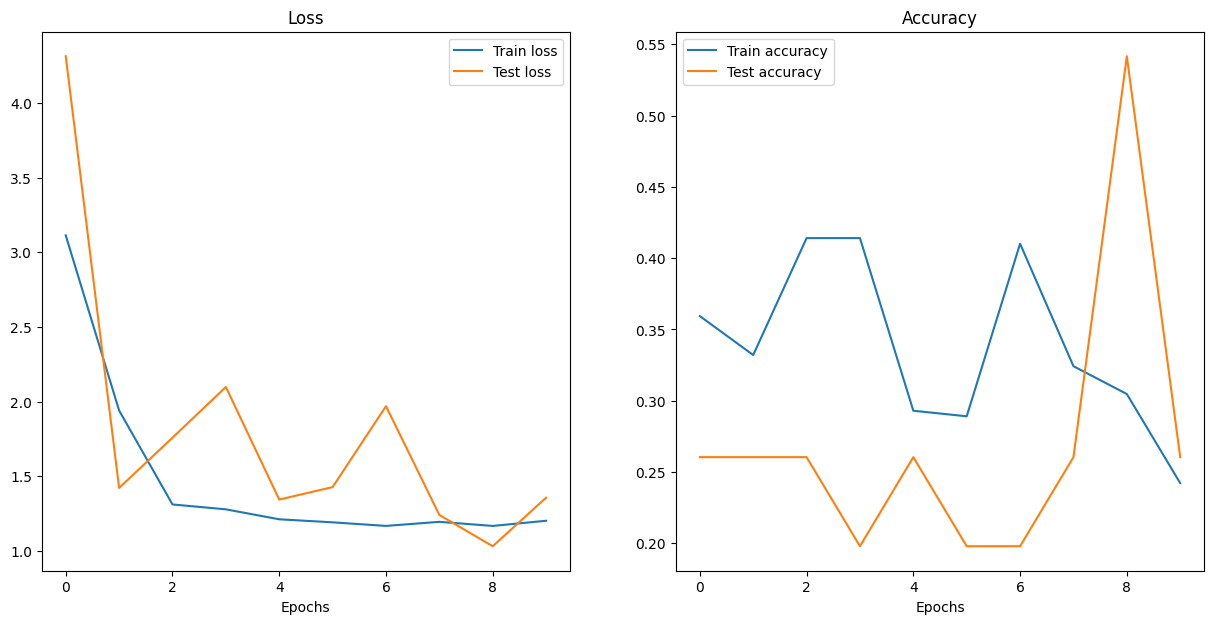

In [ ]:
# Let's take a look at the loss and accuracy graphs
helper.plot_loss_accuracy_curves(results)

Let's use a pretrained ViT from torchvision.models on the same dataset

In [ ]:
# Get weights
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup ViT model
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze base parameters
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Change classifier
helper.set_seeds()
pretrained_vit.heads = nn.Linear(in_features=OUT_SHAPE, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 167MB/s]


In [ ]:
# Pretrained model architecture
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Let's create paths for training and testing directoreis
image_path = helper.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                  destination='pizza_steak_sushi')

train_dir = image_path / 'train'
test_dir = image_path / 'test'

data/pizza_steak_sushi is already exists


In [ ]:
# Let's see automatic transform
vit_weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup data loaders
train_dataloader, test_dataloader, class_names = helper.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=vit_weights.transforms(),
                                                                           batch_size=BATCH_SIZE)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

In [ ]:
# Train pretrained model
results = helper.train(model=pretrained_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.8004 | train accuracy: 0.7188 | test loss: 0.5354 | test accuracy: 0.8769
Epoch: 2 | train loss: 0.3782 | train accuracy: 0.9336 | test loss: 0.3577 | test accuracy: 0.9081
Epoch: 3 | train loss: 0.3803 | train accuracy: 0.8242 | test loss: 0.2496 | test accuracy: 0.9384
Epoch: 4 | train loss: 0.1848 | train accuracy: 0.9531 | test loss: 0.2636 | test accuracy: 0.8883
Epoch: 5 | train loss: 0.1977 | train accuracy: 0.9570 | test loss: 0.2702 | test accuracy: 0.8883
Epoch: 6 | train loss: 0.3238 | train accuracy: 0.8398 | test loss: 0.2768 | test accuracy: 0.8883
Epoch: 7 | train loss: 0.1262 | train accuracy: 0.9688 | test loss: 0.2666 | test accuracy: 0.8987
Epoch: 8 | train loss: 0.1283 | train accuracy: 0.9766 | test loss: 0.2352 | test accuracy: 0.9384
Epoch: 9 | train loss: 0.0962 | train accuracy: 0.9844 | test loss: 0.2087 | test accuracy: 0.9280
Epoch: 10 | train loss: 0.0892 | train accuracy: 0.9805 | test loss: 0.2023 | test accuracy: 0.9280


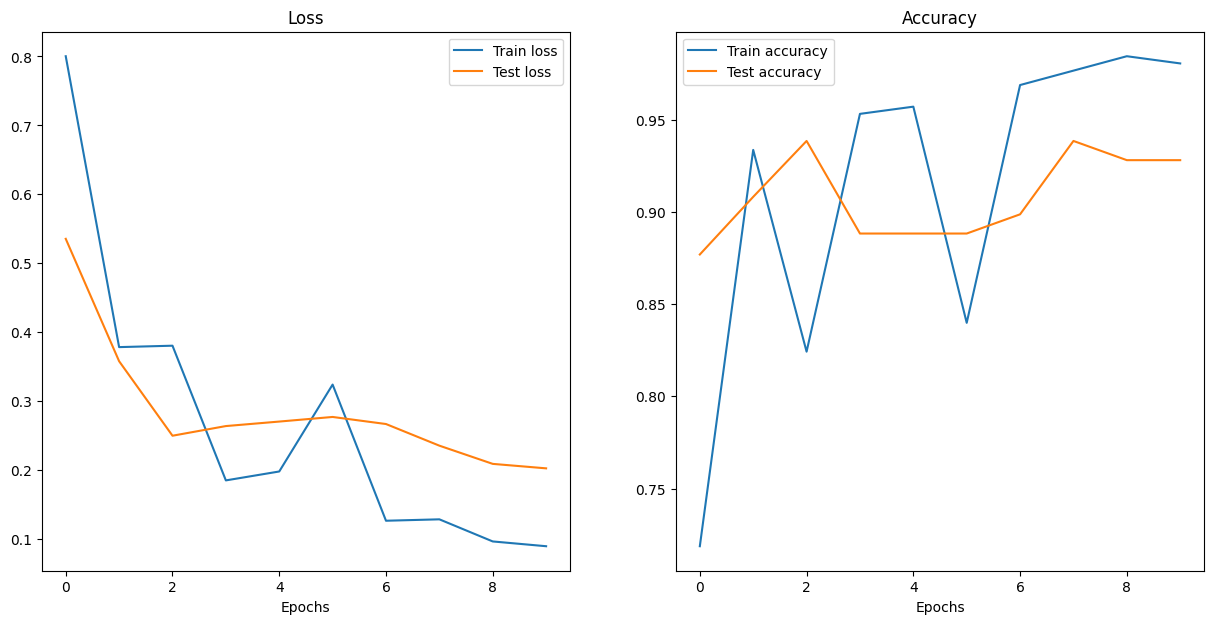

In [ ]:
# Let's take a look at the loss and accuracy graphs
helper.plot_loss_accuracy_curves(results)

In [ ]:
helper.save_model(model=pretrained_vit,
                  target_dir='models',
                  model_name='pretrained_vit.pth')

Model saved in models/pretrained_vit.pth


In [ ]:
# Check model size
pretrained_vit_size = Path('models/pretrained_vit.pth').stat().st_size // (1024 * 1024)
print(f'Size: {pretrained_vit_size} MB')

Size: 327 MB
